## Data

In [7]:
import os
import glob
import numpy as np
import cv2
from skimage import io
import matplotlib.pyplot as plt

def normalize_image(np_img):
    if np_img.max() > 0:
        # Create mask of non-background pixels
        foreground_mask = np_img > 0.01
        if foreground_mask.any():
            # Get min/max of only foreground pixels
            fg_min = np_img[foreground_mask].min()
            fg_max = np_img[foreground_mask].max()
            
            # Normalize only foreground pixels to [0,1] range
            if fg_max > fg_min:
                np_img[foreground_mask] = (np_img[foreground_mask] - fg_min) / (fg_max - fg_min)
    
    # Force background to be true black
    np_img[np_img < 0.01] = 0
    return np_img

def load_patient_data(base_path):
    """
    Load OCT B-scans for a patient from the specified path.
    
    Args:
        base_path: Path to the directory containing the OCT images
        
    Returns:
        List of loaded OCT scans as normalized numpy arrays
    """
    print(f"Loading data from: {base_path}")
    
    # Find all TIFF files in the directory
    files = sorted(glob.glob(os.path.join(base_path, "*.tiff")))
    if not files:
        # Try other possible extensions if no .tiff files are found
        files = sorted(glob.glob(os.path.join(base_path, "*.tif")))
    if not files:
        files = sorted(glob.glob(os.path.join(base_path, "*.png")))
    if not files:
        files = sorted(glob.glob(os.path.join(base_path, "*.jpg")))
        
    print(f"Found {len(files)} files")
    
    # Load and preprocess images
    oct_scans = []
    for file in files:
        try:
            # Read the image
            img = io.imread(file)
            
            # Convert to float32 and normalize to [0, 1]
            img = img.astype(np.float32)
            if img.max() > 1.0:
                img = img / 255.0
                
            oct_scans.append(img)
        except Exception as e:
            print(f"Error loading {file}: {e}")
    
    return oct_scans


def standard_preprocessing(oct_volume):
    preprocessed = []
    for img in oct_volume:
        # Normalize to [0, 1] if not already, just incase
        if img.max() > 1.0:
            img = img / 255.0
        
        # Add channel dimension if needed
        if len(img.shape) == 2:
            img_with_channel = img.reshape(*img.shape, 1)
        else:
            img_with_channel = img
        
        resized = cv2.resize(img_with_channel, (256, 256), interpolation=cv2.INTER_LINEAR)
        preprocessed.append(resized)

    return np.array(preprocessed)

def octa_preprocessing(preprocessed_data, n_neighbours=1, threshold=20):
    """
    Calculate OCTA images using multiple neighboring B-scans
    
    Args:
        preprocessed_data: List of OCT B-scans
        n_neighbours: Number of neighbors to consider on each side for OCTA calculation
        threshold: Percentile threshold for background masking
        
    Returns:
        List of OCTA images
    """
    n_scans = len(preprocessed_data)
    octa_images = []
    
    # For each scan position (except the edges where we don't have enough neighbors)
    for i in range(n_neighbours, n_scans - n_neighbours):
        # Collect all decorrelation values from comparing the center scan with its neighbors
        decorrelation_values = []
        center_scan = preprocessed_data[i]
        
        # Compare with previous n_neighbours scans
        for j in range(i-n_neighbours, i):
            neighbor_scan = preprocessed_data[j]
            decorr = compute_decorrelation(center_scan, neighbor_scan)
            decorrelation_values.append(decorr)
            
        # Compare with next n_neighbours scans
        for j in range(i+1, i+n_neighbours+1):
            neighbor_scan = preprocessed_data[j]
            decorr = compute_decorrelation(center_scan, neighbor_scan)
            decorrelation_values.append(decorr)
        
        # Average all decorrelation values to get final OCTA
        if decorrelation_values:
            avg_decorrelation = np.mean(np.stack(decorrelation_values), axis=0)
            thresholded_octa = threshold_octa(avg_decorrelation, center_scan, threshold)
            octa_images.append(thresholded_octa)
    
    return octa_images

def compute_decorrelation(oct1, oct2):

    numerator = (oct1 - oct2)**2
    denominator = oct1**2 + oct2**2
    
    epsilon = 1e-6  # Small constant to avoid division by zero
    decorrelation = numerator / (denominator + epsilon)
    
    return decorrelation

from skimage.filters import threshold_local
def threshold_octa(octa, oct, threshold):

    # Create mask based on OCT intensity
    background_mask = oct < np.percentile(oct, threshold)  # Bottom percentage as background
    
    if np.sum(background_mask) > 0:  # Ensure we have background pixels
        background_mean = np.mean(oct[background_mask])
        background_std = np.std(oct[background_mask])
        
        intensity_threshold = background_mean + 2 * background_std
    else:
        # If no background pixels, use a fixed threshold
        #print("No background pixels found, using fixed threshold")
        intensity_threshold = np.percentile(oct, threshold)
    
    # Create mask for significant signal
    #signal_mask = oct > intensity_threshold

    signal_mask = np.clip((oct - intensity_threshold) / (background_std * 2), 0, 1)

    #plt.imshow(octa, cmap='gray')
    #plt.show()
    
    # Apply mask to OCTA
    thresholded_octa = octa * signal_mask
    
    return thresholded_octa

def pair_data(preprocessed_data, octa_data, n_images_per_patient):
    preprocessed_data = preprocessed_data[:-1]  # Remove last scan to avoid out of bounds

    input_target = []
    j = 0
    for p, o in zip(preprocessed_data, octa_data):
        input_target.append([p, o])
        j += 1
        if j >= n_images_per_patient:
            break

    return input_target

def pair_data(preprocessed_data, octa_data, n_images_per_patient):
    # Calculate the offset due to n_neighbours
    n_neighbours = (len(preprocessed_data) - len(octa_data)) // 2
    
    input_target = []
    for i in range(len(octa_data)):
        # Match each octa image with its corresponding OCT image
        # The octa at index i corresponds to the preprocessed at index i+n_neighbours
        oct_image = preprocessed_data[i + n_neighbours]
        octa_image = octa_data[i]
        input_target.append([oct_image, octa_image])
        
        if len(input_target) >= n_images_per_patient:
            break
            
    return input_target

def remove_speckle_noise(image, min_size=5):
    """
    Remove small isolated speckles from an OCTA image
    
    Args:
        image: Input image (2D numpy array)
        min_size: Minimum size of regions to keep (in pixels)
        
    Returns:
        Cleaned image with small isolated speckles removed
    """
    import cv2
    import numpy as np
    
    # Ensure we're working with a 2D image
    if len(image.shape) > 2:
        if image.shape[2] == 1:
            image_2d = image[:,:,0]
        else:
            # Convert multi-channel to grayscale
            image_2d = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        image_2d = image
    
    # Create binary image
    binary = (image_2d > 0).astype(np.uint8)
    
    # Find connected components
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(binary, connectivity=8)
    
    # Create mask, keeping only components larger than min_size
    mask = np.zeros_like(binary)
    for i in range(1, num_labels):  # Skip background (0)
        if stats[i, cv2.CC_STAT_AREA] >= min_size:
            mask[labels == i] = 1
    
    # Apply mask to original image
    if len(image.shape) > 2:
        # For multi-channel images
        for c in range(image.shape[2]):
            image[:,:,c] = image[:,:,c] * mask
    else:
        # For single-channel images
        image = image * mask
    
    return image

def preprocessing_v2(n_patients, n_images_per_patient, n_neighbours=2, threshold=0.65):
    dataset = {}
    try:
        for i in range(1,n_patients):
            data = load_patient_data(rf"C:\Datasets\ICIP training data\ICIP training data\0\RawDataQA ({i})")

            preprocessed_data = standard_preprocessing(data)

            octa_data = octa_preprocessing(preprocessed_data, n_neighbours, threshold)

            cleaned_octa_data = []
            for octa_img in octa_data:
                cleaned_img = remove_speckle_noise(octa_img, min_size=5)
                cleaned_octa_data.append(cleaned_img)

            #input_target_data = pair_data(preprocessed_data, octa_data, n_images_per_patient)
            input_target_data = pair_data(preprocessed_data, cleaned_octa_data, n_images_per_patient)

            dataset[i] = input_target_data[5:-5]

        return dataset
    
    except Exception as e:
        print(f"Error in preprocessing: {e}")

def preprocessing_v2(n_patients, n_images_per_patient, n_neighbours=2, threshold=0.65, sample = False, post_process_size=10):
    
    if sample:
        begin = n_patients-1
    else:
        begin = 1
    dataset = {}
    try:
        for i in range(begin, n_patients):
            data = load_patient_data(rf"C:\Datasets\ICIP training data\ICIP training data\0\RawDataQA ({i})")
            preprocessed_data = standard_preprocessing(data)
            octa_data = octa_preprocessing(preprocessed_data, n_neighbours, threshold)
            
            # Clean the OCTA data
            cleaned_octa_data = []
            for octa_img in octa_data:
                cleaned_img = remove_speckle_noise(octa_img, min_size=post_process_size)
                cleaned_octa_data.append(cleaned_img)
            
            # Pair the data correctly, accounting for the offset
            input_target_data = pair_data(preprocessed_data, cleaned_octa_data, n_images_per_patient)
            
            # Store without arbitrary slicing, or use a slicing that's related to n_neighbours
            dataset[i] = input_target_data
            
        return dataset
    
    except Exception as e:
        print(f"Error in preprocessing: {e}")

In [8]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class OCTDataset(Dataset):
    def __init__(self, n_patients=40, n_images_per_patient=50, transform=None):
        """
        Dataset class for OCT images
        
        Args:
            n_patients: Number of patients to include
            n_images_per_patient: Maximum number of images per patient
            transform: Optional transforms to apply
        """
        self.transform = transform
        
        # Process OCT data
        dataset_dict = preprocessing_v2(n_patients, n_images_per_patient, n_neighbours=2)
        
        # Store image pairs
        self.input_images = []
        self.target_images = []
        
        # Create pairs of consecutive scans
        for patient_id, data in dataset_dict.items():
            for i in range(len(data) - 1):  # Use consecutive pairs
                input_image = data[i][0]  # First scan as input
                target_image = data[i+1][0]  # Next scan as target
                
                # Handle potential NaN or Inf values
                if np.isfinite(input_image).all() and np.isfinite(target_image).all():
                    self.input_images.append(input_image)
                    self.target_images.append(target_image)
    
    def __len__(self):
        return len(self.input_images)
    
    def __getitem__(self, idx):
        input_img = self.input_images[idx]
        target_img = self.target_images[idx]
        
        # Add channel dimension if needed
        if len(input_img.shape) == 2:
            input_img = input_img[:, :, np.newaxis]
            target_img = target_img[:, :, np.newaxis]
        
        # Convert to PyTorch tensors
        input_tensor = torch.from_numpy(input_img.transpose(2, 0, 1)).float()
        target_tensor = torch.from_numpy(target_img.transpose(2, 0, 1)).float()
        
        # Apply transformations if any
        if self.transform:
            input_tensor = self.transform(input_tensor)
            target_tensor = self.transform(target_tensor)
            
        return input_tensor, target_tensor
    
    

## Model

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()
        
        # Encoder (downsampling)
        self.enc1 = self._block(in_channels, 48, name="enc1")
        self.enc2 = self._block(48, 48, name="enc2")
        self.enc3 = self._block(48, 48, name="enc3")
        self.enc4 = self._block(48, 48, name="enc4")
        
        # Decoder (upsampling)
        self.dec1 = self._block(96, 96, name="dec1")
        self.dec2 = self._block(144, 96, name="dec2")
        self.dec3 = self._block(144, 96, name="dec3")
        
        # Final layer
        self.final = nn.Conv2d(96 + in_channels, out_channels, kernel_size=3, padding=1)
        
        # Max pooling
        self.pool = nn.MaxPool2d(2)
        
    def _block(self, in_channels, features, name):
        return nn.Sequential(
            nn.Conv2d(in_channels, features, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(features, features, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        # Save input for skip connection
        inp = x
        
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))
        
        # Decoder with skip connections
        dec1 = self.dec1(torch.cat([F.interpolate(enc4, scale_factor=2, mode='nearest'), enc3], dim=1))
        dec2 = self.dec2(torch.cat([F.interpolate(dec1, scale_factor=2, mode='nearest'), enc2], dim=1))
        dec3 = self.dec3(torch.cat([F.interpolate(dec2, scale_factor=2, mode='nearest'), enc1], dim=1))
        
        # Final layer with skip connection to input
        final = torch.cat([dec3, inp], dim=1)
        
        return self.final(final)

## Training

In [22]:
import torch.optim as optim
from torch.utils.data import DataLoader
import time
import os

def train_noise2noise(patients, epochs=100, batch_size=8, lr=0.001, save_dir='models'):
    # Create save directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)
    
    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Create dataset and dataloader
    dataset = OCTDataset(n_patients=patients, n_images_per_patient=50)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    
    # Initialize model, loss, and optimizer
    model = UNet(in_channels=1, out_channels=1).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Training loop
    start_time = time.time()
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        
        for batch_idx, (input_imgs, target_imgs) in enumerate(dataloader):
            # Move tensors to device
            input_imgs = input_imgs.to(device)
            target_imgs = target_imgs.to(device)
            
            # Forward pass
            outputs = model(input_imgs)
            loss = criterion(outputs, target_imgs)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            
            # Print progress
            if (batch_idx + 1) % 10 == 0:
                print(f"Epoch [{epoch+1}/{epochs}], Batch [{batch_idx+1}/{len(dataloader)}], Loss: {loss.item():.6f}")
        
        # Print epoch results
        avg_epoch_loss = epoch_loss / len(dataloader)
        print(f"Epoch [{epoch+1}/{epochs}], Average Loss: {avg_epoch_loss:.6f}")
        
        # Save model checkpoint
        if (epoch + 1) % 5 == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_epoch_loss
            }, os.path.join(save_dir, f'model_epoch_{epoch+1}.pth'))
    
    # Save final model
    torch.save(model.state_dict(), os.path.join(save_dir, 'noise2noise_final.pth'))
    
    elapsed_time = time.time() - start_time
    print(f"Training completed in {elapsed_time / 60:.2f} minutes")
    
    return model

## Main

In [25]:
model = train_noise2noise(2, epochs=10, batch_size=8, lr=0.001)

Using device: cuda
Loading data from: C:\Datasets\ICIP training data\ICIP training data\0\RawDataQA (1)
Found 52 files
Epoch [1/10], Average Loss: 0.290389
Epoch [2/10], Average Loss: 0.117315
Epoch [3/10], Average Loss: 0.136376
Epoch [4/10], Average Loss: 0.058501
Epoch [5/10], Average Loss: 0.019283
Epoch [6/10], Average Loss: 0.007562
Epoch [7/10], Average Loss: 0.006062
Epoch [8/10], Average Loss: 0.004913
Epoch [9/10], Average Loss: 0.005052
Epoch [10/10], Average Loss: 0.004995
Training completed in 0.22 minutes


Loading data from: C:\Datasets\ICIP training data\ICIP training data\0\RawDataQA (1)
Found 52 files


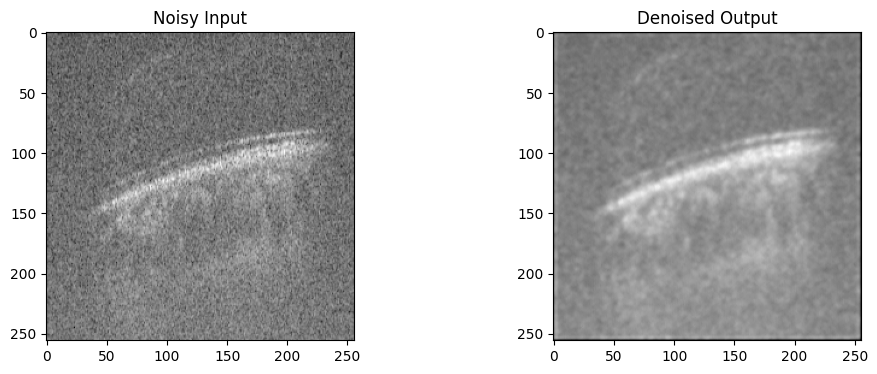

In [27]:
def denoise_image(model, image, device=None):
    """Apply model to denoise a single image"""
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    model.eval()
    
    # Prepare input
    if len(image.shape) == 2:
        image = image[:, :, np.newaxis]
    
    # Convert to tensor and add batch dimension
    input_tensor = torch.from_numpy(image.transpose(2, 0, 1)).float().unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(input_tensor)
    
    # Convert back to numpy
    output_image = output.squeeze().cpu().numpy()
    
    # Handle single-channel case
    if len(output_image.shape) == 2:
        return output_image
    else:
        return output_image.transpose(1, 2, 0)

test_dataset = preprocessing_v2(2, 50, sample=True)
test_img = list(test_dataset.values())[0][0][0]
denoised = denoise_image(model, test_img)

# Visualize results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(test_img, cmap='gray')
plt.title('Noisy Input')

plt.subplot(1, 2, 2)
plt.imshow(denoised, cmap='gray')
plt.title('Denoised Output')

plt.savefig('denoising_result.png')
plt.show()